In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

ROOT = "/content/drive/MyDrive/cnn_task"
os.chdir(ROOT)

In [3]:
from zipfile import ZipFile
import traceback

In [4]:
def unzip(file='archive (1).zip'):
    try:
        if not "shoeTypeClassifierDataset" in os.listdir():
            print("Extracting...")
            zf = ZipFile(file, 'r')
            zf.extractall(os.getcwd())
            zf.close()
        else:
            print("Dataset already extracted")
    except Exception as e:
        print(e)
        traceback.print_exc()

unzip()

Extracting...


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
# Define directories
train_dir = "/content/drive/MyDrive/cnn_task/shoeTypeClassifierDataset/training"
test_dir = "/content/drive/MyDrive/cnn_task/shoeTypeClassifierDataset/validation"


In [7]:
# Define image size and batch size
image_size = (224, 224)
batch_size = 32

In [8]:
# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)  # 20% validation split
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [9]:
# Create Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 1199 images belonging to 6 classes.


In [10]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 294 images belonging to 6 classes.


In [11]:
from tensorflow.keras import models, layers

In [12]:
model = models.Sequential()

In [13]:
# First block
model.add(layers.Conv2D(8, (3, 3), activation="relu", input_shape=(224, 224, 3)))
model.add(layers.Conv2D(8, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Dropout(0.1))

# Second block
model.add(layers.Conv2D(16, (3, 3), activation="relu"))
model.add(layers.Conv2D(16, (3, 3), activation="relu"))
model.add(layers.Dropout(0.1))
model.add(layers.MaxPooling2D((6, 6)))

# Flatten and Dense Layer
model.add(layers.Flatten())
model.add(layers.Dense(6, activation="softmax"))  # 6 classes

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 8)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 73, 73, 8)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 16)        2320      
                                                        

In [16]:
# Train the model
model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

Epoch 1/25
38/38 [==============================] - 36s 759ms/step - loss: 1.7852 - accuracy: 0.1952 - val_loss: 1.7742 - val_accuracy: 0.2381
Epoch 2/25
38/38 [==============================] - 23s 602ms/step - loss: 1.7481 - accuracy: 0.2686 - val_loss: 1.7471 - val_accuracy: 0.2789
Epoch 3/25
38/38 [==============================] - 23s 596ms/step - loss: 1.6177 - accuracy: 0.3453 - val_loss: 1.6724 - val_accuracy: 0.3571
Epoch 4/25
38/38 [==============================] - 24s 630ms/step - loss: 1.4550 - accuracy: 0.4337 - val_loss: 1.6010 - val_accuracy: 0.4150
Epoch 5/25
38/38 [==============================] - 22s 594ms/step - loss: 1.3320 - accuracy: 0.4887 - val_loss: 1.5503 - val_accuracy: 0.4082
Epoch 6/25
38/38 [==============================] - 22s 591ms/step - loss: 1.2474 - accuracy: 0.5496 - val_loss: 1.5123 - val_accuracy: 0.4558
Epoch 7/25
38/38 [==============================] - 23s 617ms/step - loss: 1.1801 - accuracy: 0.5730 - val_loss: 1.5439 - val_accuracy: 0.4286

In [17]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc}")

10/10 [==============================] - 4s 398ms/step - loss: 2.6894 - accuracy: 0.4592
Test accuracy: 0.4591836631298065


In [18]:
# We got only 45% accuracy on the Testing dataset now we will use Transfer Learining to increase Accuracy

In [19]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [20]:
# effiecient net
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [21]:
# Function to create the model
def create_model(model_url, num_classes):
    feature_extractor_layer = hub.KerasLayer(model_url, trainable=False, name='FEL', input_shape=(224, 224, 3))

    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layers")
    ])
    return model


In [25]:
# Number of classes in your dataset
num_classes = 6  # Update this to match your dataset

# Create the model
efficient_model = create_model(efficientnet_url, num_classes=num_classes)


In [26]:
# Compile the model
efficient_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
# Train the model
efficient_history = efficient_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

Epoch 1/20
38/38 [==============================] - 39s 770ms/step - loss: 1.4310 - accuracy: 0.4712 - val_loss: 1.1926 - val_accuracy: 0.6190
Epoch 2/20
38/38 [==============================] - 23s 599ms/step - loss: 0.8523 - accuracy: 0.7606 - val_loss: 0.9431 - val_accuracy: 0.6803
Epoch 3/20
38/38 [==============================] - 23s 607ms/step - loss: 0.6562 - accuracy: 0.8107 - val_loss: 0.8399 - val_accuracy: 0.7007
Epoch 4/20
38/38 [==============================] - 21s 565ms/step - loss: 0.5504 - accuracy: 0.8465 - val_loss: 0.7845 - val_accuracy: 0.7211
Epoch 5/20
38/38 [==============================] - 22s 587ms/step - loss: 0.4736 - accuracy: 0.8707 - val_loss: 0.7628 - val_accuracy: 0.7381
Epoch 6/20
38/38 [==============================] - 21s 558ms/step - loss: 0.4180 - accuracy: 0.8874 - val_loss: 0.7377 - val_accuracy: 0.7449
Epoch 7/20
38/38 [==============================] - 22s 586ms/step - loss: 0.3754 - accuracy: 0.8982 - val_loss: 0.7134 - val_accuracy: 0.7585

In [28]:
# Evaluate the model on the test set
test_loss, test_acc = efficient_model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc}")

10/10 [==============================] - 4s 399ms/step - loss: 0.6825 - accuracy: 0.7789
Test accuracy: 0.7789115905761719


In [29]:

# Save the trained model for later use
efficient_model.save('efficientnet_b0_shoes_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [34]:
# Retrieve class indices
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())
print("Class labels:", class_labels)

Class labels: ['boots', 'flip_flops', 'loafers', 'sandals', 'sneakers', 'soccer_shoes']


1/1 [==============================] - 1s 779ms/step
Predicted label: flip_flops
Prediction scores: [4.7534148e-05 9.8340338e-01 8.0496684e-05 1.5803894e-02 1.9250934e-05
 6.4546976e-04]


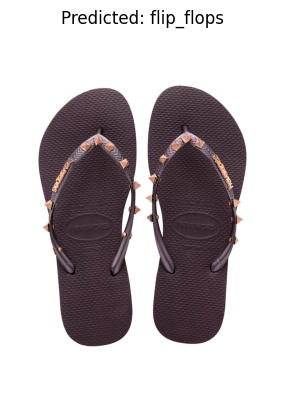

In [35]:

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create batch axis
    img_array /= 255.0  # Normalize the image
    return img_array

# Function to make predictions
def predict_image(model, img_path):
    preprocessed_image = preprocess_image(img_path)
    predictions = model.predict(preprocessed_image)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]
    return predicted_label, predictions[0]

# Load the saved model
saved_model = tf.keras.models.load_model('efficientnet_b0_shoes_classifier.h5', custom_objects={'KerasLayer': hub.KerasLayer})

# Path to the image you want to predict
image_path = '/content/drive/MyDrive/cnn_task/shoeTypeClassifierDataset/validation/flip_flops/image257.jpeg'

# Make a prediction
predicted_label, prediction_scores = predict_image(saved_model, image_path)

print(f"Predicted label: {predicted_label}")
print(f"Prediction scores: {prediction_scores}")

# Plot the image with the prediction
img = image.load_img(image_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()